# Stable set benchmarking

In this notebook we look at solving the smallest stable set instance on 17 qubits based on mammalia-kangaroo-interactions.gph.

### Load the graph

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import networkx as nx
import numpy as np
from time import time
from collections import defaultdict

from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

from qiskit_aer import AerSimulator

from qiskit_optimization.applications import StableSet
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

from independent_set_benchmarking.analysis import counts_to_cost_val, to_cdf, random_sampling, average_results
from independent_set_benchmarking.utils import load_graph, save_hardware_result
from independent_set_benchmarking.transpile import circuit_construction
from independent_set_benchmarking.post_process import greedy_post_process
from independent_set_benchmarking.optimization import optimize_lambda, plot_lambda_optimization

In [2]:
file_name = "mammalia-kangaroo-interactions.gph"

graph, original_graph = load_graph(f"../instances/{file_name}")

## Preprocessing: Remap the graph taking hardware constraints into account

The following simplification are tailored to the `"instances/mammalia-kangaroo-interactions.gph"` instance. This involves us designing a SWAP strategy tailored to a graph where 15 nodes have a high degree (almost fully connected) and two nodes have a low degree, here 1 and 2. To deal with this situation we apply a fully connected SWAP strategy to the dense core of 15 nodes. This saves us an estimated 60 CX gates. Note: the SAT mapper does not help us here.

In [3]:
for nnodes in [17, 15]:
    print(f"Full connectivty on {nnodes} nodes requires", (nnodes-2)*(nnodes-1)/2, "SWAP gates")

Full connectivty on 17 nodes requires 120.0 SWAP gates
Full connectivty on 15 nodes requires 91.0 SWAP gates


In [4]:
start = time()
unmapped_nodes = set(range(graph.order()))
free_nodes = set(range(graph.order()))
mapping = {7: 1, 11: 0, 9: 2, 6: 16, 15: 15}
for key, val in mapping.items():
    unmapped_nodes.remove(key)
    free_nodes.remove(val)

free_nodes = list(free_nodes)
for node in unmapped_nodes:
    mapping[node] = free_nodes.pop(-1)
    
remapped_graph = nx.relabel_nodes(graph, mapping, copy=True)
time() - start

0.0

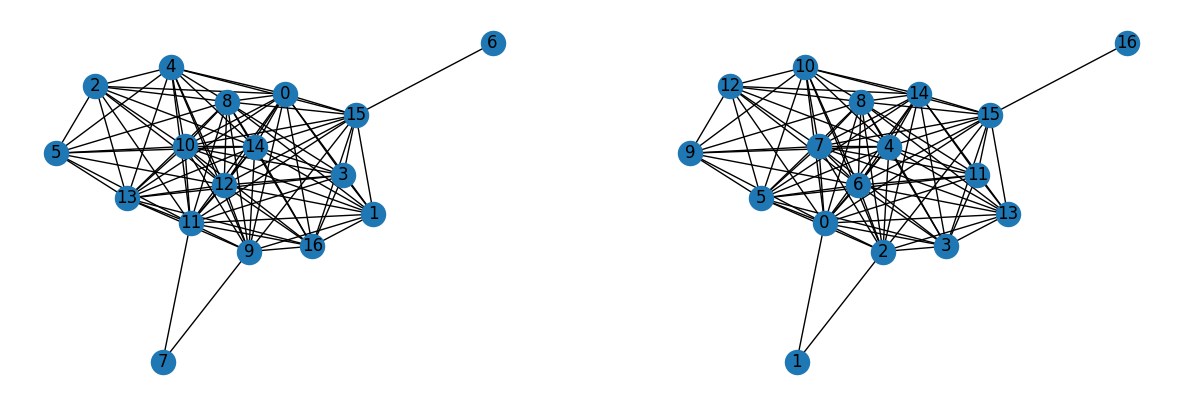

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
nx.draw_kamada_kawai(graph, ax=axs[0], with_labels=True)
nx.draw_kamada_kawai(remapped_graph, ax=axs[1], with_labels=True)

Now, we create a SWAP strategy tailored to our problem. From this we will later build a hardware native circuit.

In [6]:
start = time()
layers = [tuple([tuple((0, 1))])]
for layer_idx in range(13):
    if layer_idx % 2 == 1:
        layer = tuple((idx + 1, idx + 2) for idx in range(1, 15, 2))
    else:
        layer = tuple((idx, idx + 1) for idx in range(1, 15, 2))
    layers.append(layer)

cmap = CouplingMap([(idx, idx + 1) for idx in range(17)])
cmap.make_symmetric()

swap_strat = SwapStrategy(coupling_map=cmap, swap_layers=layers)
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(17)}
time() - start

0.0010008811950683594

## Create the QUBO for QAOA and optimize the parameters

Here, we explore a procedure to optimize the lagrange multiplier. Before, showing how we do this we first introduce the independent set problem and some notation. The independent set problem is
\begin{align}
\max_x \sum_{i=0}^{|V|-1} x_i \\
\text{s.t.} ~x_ux_v=0~\forall (u,v)\in E
\end{align}
We can formulate this as the following maximization problem
\begin{align}
\max_x \sum_{u\in V} x_u -\lambda \sum_{(u,v)\in E} x_ux_v
\end{align}
The first term is called the objective and the second is the constraint.
We can convert these to a Hamiltonian with the variable change $x_i=(1-z_i)/2$.
With this the objective becomes
\begin{align}
\sum_ix_i=\frac{|V|}{2}-\frac{1}{2}\sum_i z_i=\frac{|V|}{2}+H_\text{obj.}.
\end{align}
Here, the first term is the objective offset.
The constraint is mapped to
\begin{align}
-\lambda \sum_{(u,v)\in E} x_ux_v=-\frac{\lambda}{4} \sum_{(u,v)\in E} 1-z_i-z_j+z_iz_j=-\lambda\frac{|E|}{4}+\lambda H_\text{const.}
\end{align}
Now, to optimize the Lagrange multiplier $\lambda$ we will seek to put an equal amount of weight on the objective and constraint expectation values.
\begin{align}
\max_\lambda~\min\left(\langle H_\text{obj}\rangle^\star, \langle H_\text{const.}\rangle^\star\right)
\end{align}
Here, the expectation values $\langle\cdot\rangle^\star$ are taken over the QAOA state with the optimal $\beta$ and $\gamma$ at a fixed $\lambda$.
These values are found as
\begin{align}
(\beta^\star(\lambda), \gamma^\star(\lambda))={\rm argmax}_{\beta, \gamma}~\langle \psi(\beta, \gamma)|H_\text{obj.} +\lambda H_\text{const.}|\psi(\beta, \gamma)\rangle={\rm argmax}_{\beta, \gamma} \langle \psi(\beta, \gamma)|H_C|\psi(\beta, \gamma)\rangle = {\rm argmax}_{\beta, \gamma}~E(\beta,\gamma; \lambda).
\end{align}
For convenience we define $E_\text{obj.}^\star=\langle \psi(\beta^\star, \gamma^\star)|H_\text{obj.}|\psi(\beta^\star, \gamma^\star)\rangle$.
Therefore, with the quantities implicitly defined by the equations above, we can re-write the Lagrange multiplier optimization as
\begin{align}
\max_\lambda~\min\left(E_\text{obj.}^\star, (E(\beta^\star,\gamma^\star; \lambda) - E_\text{obj.}^\star)\right)=\max_\lambda F(\lambda)
\end{align}

In [7]:
lambdas_scan = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]

results = optimize_lambda(remapped_graph, lambdas_scan)
print("Time taken to find lambda, beta, and gamma: ", results["train_duration"], "seconds")

Time taken to find lambda, beta, and gamma:  22.12155795097351 seconds


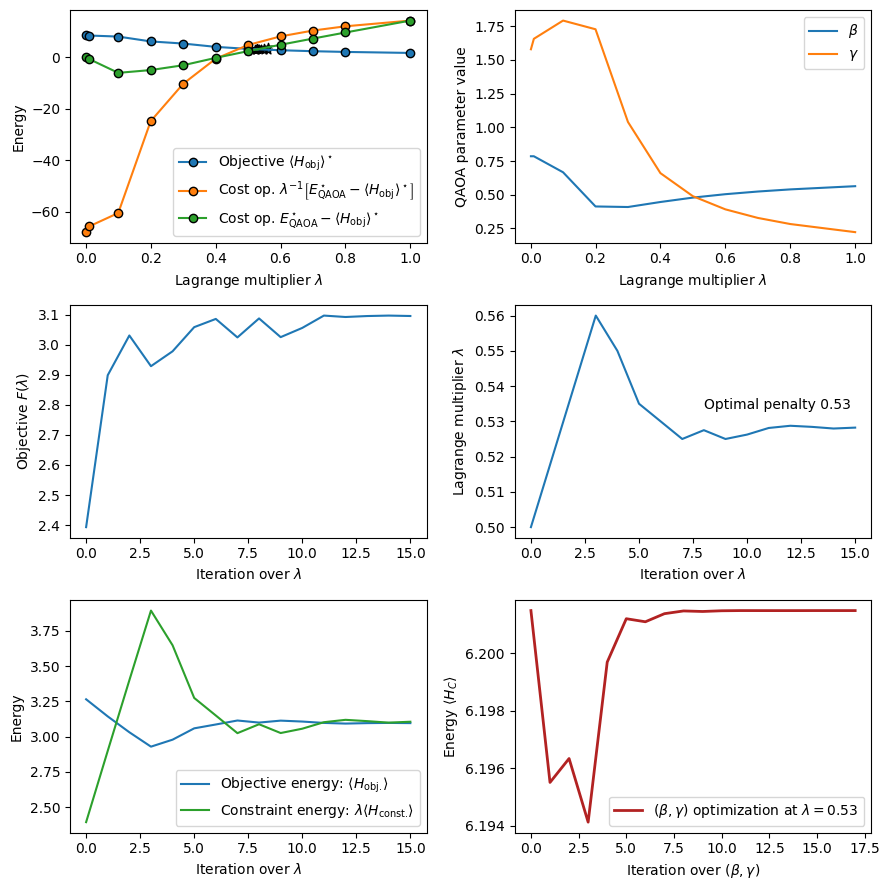

In [8]:
fig, axs = plot_lambda_optimization(results, lambdas_scan)

In [9]:
fig.savefig("../plots/kangaroo_lambda_optimization.pdf", bbox_inches="tight")

### Circuit construction

Construct the circuits. This will construct several circuits corresponding to different stages of the circuit construction pipeline

In [10]:
service = QiskitRuntimeService(instance="...")

backend = service.backend("ibm_fez", use_fractional_gates=False)

In [11]:
start = time()

penalties = [float(results["scipy"]["history"][-1][1])]
p = [results["scipy"]["all_results"][-1]["optimized_params"]]
metadatas = [{"lambda": penalty} for penalty in penalties]

instance = StableSet(remapped_graph)
qp = instance.to_quadratic_program()

qubos, cost_ops, offsets, singles, doubles = [], [], [], [], []

for penalty in penalties:
    qubo = QuadraticProgramToQubo(penalty=penalty).convert(qp)
    cost_op, offset = qubo.to_ising()
    qubos.append(qubo)
    cost_ops.append(-cost_op)
    offsets.append(-offset)
    singles.append(cost_ops[-1][cost_ops[-1].paulis.z.sum(axis=-1) == 1])
    doubles.append(cost_ops[-1][cost_ops[-1].paulis.z.sum(axis=-1) == 2])

all_circuits = [
    circuit_construction(singles[idx], doubles[idx], p[idx], backend, swap_strat, edge_coloring, metadatas[idx]) for idx in range(len(penalties))
]
circ_construction_time = time() - start
print(f"Circuit construction time is {circ_construction_time} seconds.")

Circuit construction time is 4.934507131576538 seconds.


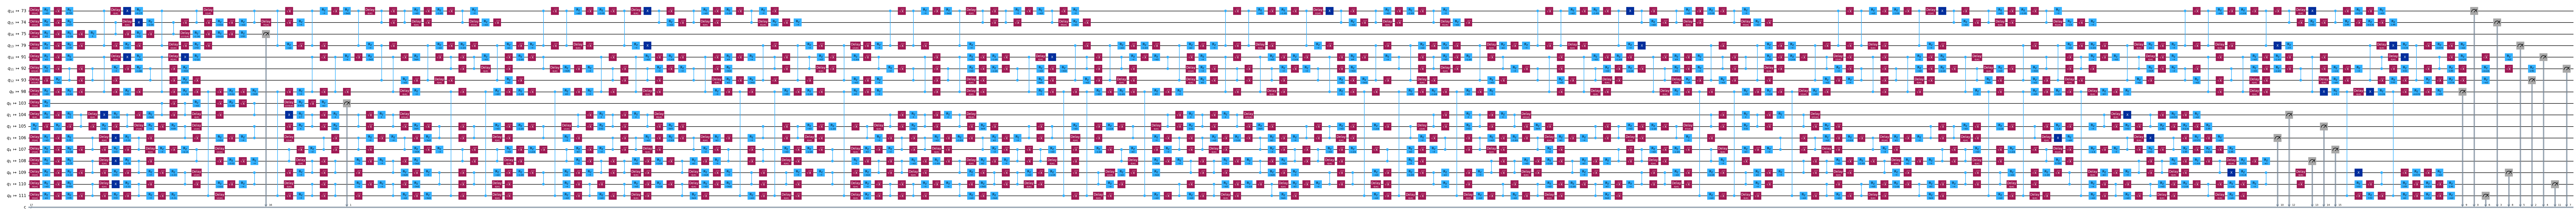

In [12]:
all_circuits[0]["backend"].draw("mpl", fold=False, idle_wires=False)

In [13]:
all_circuits[0]["backend"].metadata

{'lambda': 0.5282250000000001,
 'parameters': [0.4862885074048559, 0.4564435649756162]}

In [14]:
all_circuits[0]["backend"].count_ops()

OrderedDict([('sx', 694),
             ('rz', 539),
             ('delay', 310),
             ('cz', 308),
             ('x', 27),
             ('measure', 17)])

#### Get baseline with CPLEX

In [15]:
cplex_res = CplexOptimizer().solve(qp)
cplex_res

<OptimizationResult: fval=4.0, x_0=0.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0, x_10=0.0, x_11=1.0, x_12=0.0, x_13=0.0, x_14=0.0, x_15=0.0, x_16=1.0, status=SUCCESS>

### First execute on the simulator

Here, we execute on Aer and compare to random sampling.

In [16]:
fake_sampler = Sampler(mode=AerSimulator())
fake_results = [fake_sampler.run([circs["circuit_to_sample"] for circs in all_circuits], shots=1024).result() for _ in range(5)]

In [17]:
aer_cost_vals, aer_infeasibles, aer_all = [], [], []

for res in fake_results:
    cv, inf = counts_to_cost_val(remapped_graph, res[0].data.c.get_counts())
    aer_cost_vals.append(cv)
    aer_infeasibles.append(inf)

    aer_all.append({key: inf.get(key, 0) + cv.get(key, 0)  for key in set(inf.keys()) | set(cv.keys())})

In [18]:
rand_alls, rand_all_cost_vals, rand_all_infs = [], [], []

for _ in range(5):
    rand_cost_vals, rand_inf, rand_samples = random_sampling(1024, remapped_graph)
    rand_alls.append({key: rand_inf.get(key, 0) + rand_cost_vals.get(key, 0)  for key in set(rand_inf.keys()) | set(rand_cost_vals.keys())})
    rand_all_cost_vals.append(rand_cost_vals)
    rand_all_infs.append(rand_inf)

## Execute on hardware

We execute the quantum circuit with the trained parameters on *ibm_fez*; an IBM Quantum superconducting qubit based device with a controlled-phase gate as a two-qubit gate.

In [17]:
sampler_jobs = []

for _ in range(5):
    with Session(backend=backend) as session:
        samplerb = Sampler(mode=session)
        sampler_job = samplerb.run([all_circuits[idx]["backend"] for idx in range(len(penalties))], shots=1024)
        sampler_jobs.append(sampler_job)

In [18]:
for sampler_job in sampler_jobs:
    print(sampler_job.job_id())

cy37rwv6vek0008reqbg
cy37rxv9b62g008hatdg
cy37ryk9b62g008hate0
cy37rzk9b62g008hatf0
cy37s0crta1g0086tce0


Load the job to be able to analyze its results.

In [19]:
sampler_jobs, fez_results = [], []
save = False

for idx, job_id in enumerate(["cy37rwv6vek0008reqbg", "cy37rxv9b62g008hatdg", "cy37ryk9b62g008hate0", "cy37rzk9b62g008hatf0", "cy37s0crta1g0086tce0"]):

    sampler_job = service.job(job_id)
    sampler_jobs.append(sampler_job)

    if save:
        save_hardware_result(sampler_job, f"kangaroo_final{idx}")

    fez_results.append(sampler_job.result())

In [20]:
fez_cost_vals, fez_infeasibles, fez_all = [], [], []

for res in fez_results:
    cv, inf = counts_to_cost_val(remapped_graph, res[0].data.c.get_counts())
    fez_cost_vals.append(cv)
    fez_infeasibles.append(inf)

    fez_all.append({key: inf.get(key, 0) + cv.get(key, 0)  for key in set(inf.keys()) | set(cv.keys())})

## Result plotting

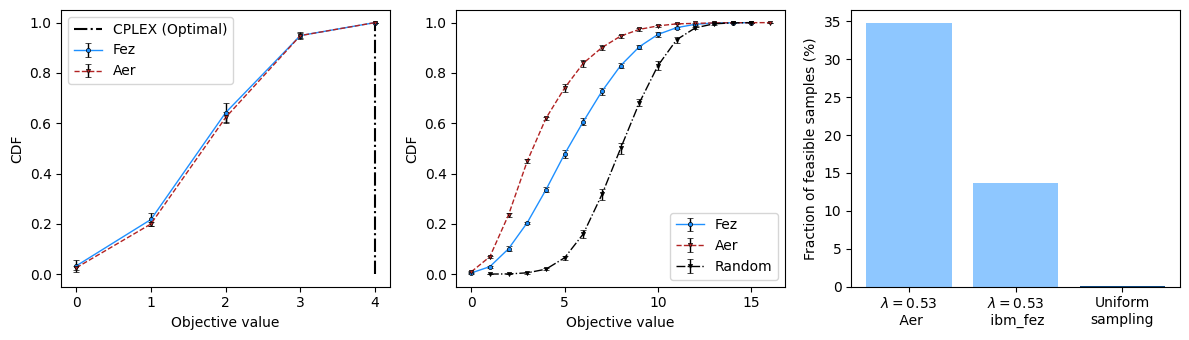

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

nff, nfi = sum(rand_cost_vals.values()), sum(rand_inf.values())
axs[2].bar([2], [100*nff / (nff + nfi)], color="k")

opts = {"lw": 1, "color": "dodgerblue", "ms": 3, "marker": "o", "ecolor": "k", "elinewidth": 1, "capsize": 2, "mec": "k", "mew": 0.5}
opts["label"] = "Fez"
axs[0].errorbar(**average_results(fez_cost_vals, opts))
axs[1].errorbar(**average_results(fez_all, opts))

opts.update({"marker": "v", "color": "firebrick", "ls": "--", "label": "Aer"})
axs[0].errorbar(**average_results(aer_cost_vals, opts))
axs[1].errorbar(**average_results(aer_all, opts))

for idx, vals in enumerate([(aer_cost_vals, aer_infeasibles), (fez_cost_vals, fez_infeasibles), (rand_all_cost_vals, rand_all_infs)]):
    feasible = []
    for jidx, val in enumerate(vals[0]):
        feasible.append(sum(val.values()) / (sum(val.values()) + sum(vals[1][jidx].values())))

    axs[2].bar([idx], 100 * np.average(feasible), color="dodgerblue", alpha=0.5)

for ax in axs[0:2]:
    ax.set_xlabel("Objective value")
    ax.set_ylabel("CDF")

axs[1].legend()
axs[2].set_xticks(range(len(penalties)+2))
axs[2].set_xticklabels([f"$\lambda={penalties[0]:.2f}$\n Aer", f"$\lambda={penalties[0]:.2f}$\n ibm_fez", "Uniform\nsampling"])
axs[2].set_ylabel("Fraction of feasible samples (%)")
axs[0].vlines(cplex_res.fval, 0, 1, color="k", ls="-.", label="CPLEX (Optimal)")
axs[0].legend()
fig.tight_layout()
fig.savefig("../plots/kangaroo_samples.pdf", bbox_inches="tight")

opts.update({"marker": "v", "color": "k", "ls": "-.", "label": "Random"})
axs[1].errorbar(**average_results(rand_alls, opts))
axs[1].legend()

### Problem specific post-processing

Here we run through the following post processing.

**Step 1: Enforce feasibility**

* For every selected node, determine the number of violated constraints (= number of edges that point back to the selected subset of nodes).
* Sort by number of violations.
* Remove the node with the largest number of violations and update the number of violations for the remaining nodes
* Repeat until all violations have been resolved

**Step 2: Improve solution while staying feasible**

* For all not selected nodes, determine whether adding them to the set would violate the constraints.
* Start adding nodes to the solution in some order and update which ones are feasible (= remove all neighbors of nodes that have been added). As a rule of thumb one could pick the nodes sorted by their degree and prefer nodes that have a small number of edges or just randomly pick from the feasible ones.

In [22]:
rand_counts = defaultdict(float)
for sample in rand_samples:
    rand_counts["".join([str(val) for val in sample[::-1]])] += 1

Post processing time 0.15101542472839355 +- 0.007711403415897443 seconds


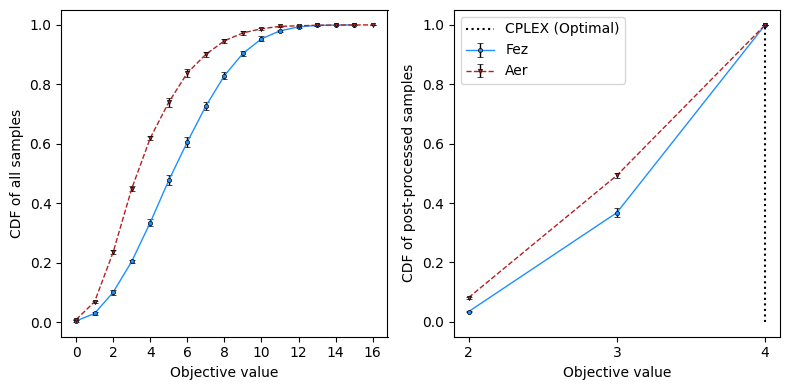

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

opts = {"lw": 1, "color": "dodgerblue", "ms": 3, "marker": "o", "ecolor": "k", "elinewidth": 1, "capsize": 2, "mec": "k", "mew": 0.5}
opts["label"] = "Fez"
axs[0].errorbar(**average_results(fez_all, opts))

cvs, times, best_sols, best_vals = [], [], [], []
for res in fez_results:
    start = time()
    cv, best_sol, best_val = greedy_post_process(res[0].data.c.get_counts(), remapped_graph)
    times.append(time() - start)
    cvs.append(cv)
    best_sols.append(best_sol)
    best_vals.append(best_val)
    
print(f"Post processing time {np.average(times)} +- {np.std(times)} seconds")

axs[1].errorbar(**average_results(cvs, opts))

opts.update({"marker": "v", "color": "firebrick", "ls": "--", "label": "Aer"})
axs[0].errorbar(**average_results(aer_all, opts))
axs[0].set_ylabel("CDF of all samples")
axs[0].set_xlabel("Objective value")
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

cvs = [greedy_post_process(res[0].data.c.get_counts(), remapped_graph)[0] for res in fake_results]
axs[1].errorbar(**average_results(cvs, opts))

axs[1].vlines(cplex_res.fval, 0, 1, color="k", ls=":", label="CPLEX (Optimal)")
axs[1].set_xlabel("Objective value")
axs[1].set_ylabel("CDF of post-processed samples")
axs[1].legend()
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
fig.savefig("../plots/kangaroo_post_processed.pdf", bbox_inches="tight")

The following show the probabilities with which to sample the optimal solution.

In [24]:
for idx, res in enumerate(fake_results):
    print(greedy_post_process(res[0].data.c.get_counts(), remapped_graph)[0][cplex_res.fval]/1024)

0.517578125
0.509765625
0.4990234375
0.5107421875
0.4970703125


In [25]:
greedy_post_process(rand_counts, remapped_graph)[0][cplex_res.fval]/1024

0.8095703125

In [26]:
for idx, res in enumerate(fez_results):
    print(greedy_post_process(res[0].data.c.get_counts(), remapped_graph)[0][cplex_res.fval]/1024)

0.6220703125
0.6123046875
0.640625
0.6298828125
0.65625


In [27]:
best_sols[0]

{(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1),
 (0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1),
 (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1),
 (0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1),
 (0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1),
 (0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1)}

In [28]:
import json

for idx, best_sol in enumerate(best_sols):
    with open(f"../solutions/mammalia-kangaroo-interactions{idx}.json", "w") as fout:
        json.dump(tuple(best_sol), fout)

In [29]:
best_vals

[4, 4, 4, 4, 4]

## Execution times

## Summary

**Problem:** 			`mammalia-kangaroo-interactions.gph`

**Submitter:** 			Daniel J. Egger, IBM Quantum

**Hardware:**			Superconducting qubit hardware for sampling: Heron R2 ibm_fez.

**Software:**			Qiskit 1.2.2

**Deterministic / Probabilistic:** 	The QAOA parameter training is deterministic. The quantum sampling is probabilistic.

**Best Found Objective Value:**	4 (Optimal)

**Best Found Solution:**	00100000000110001 and others, see solutions/mammalia-kangaroo-interactionsX.json

**Lower Bound / Optimality Gap:** 	N/A.

**Number of Runs:**	5

**Number of Feasible Runs:** 	5/5

**Number of Successful Runs:**	5/5

**Runtime reporting:**

-	Quantum circuit parameter optimization: 22 seconds
-   Quantum circuit construction time: 5 seconds
-   Quantum circuit execution time (without queuing): 60 seconds (includes compilation and sampling) `finished - running`
-   Post processing of quantum samples: 0 seconds

**Overall Runtime:**	87 seconds

**Pre-Processing:**	    27 seconds

**Pre-Solve Time:**		0 seconds

**Size after Pre-Solve:**	All variables and all constraints were implemented on the QPU.

**Post-Processing Time:**	0 seconds

**CPU Runtime:**	27 seconds

**GPU Runtime:**	NA

**Other HW Runtime:**	NA

**QPU Runtime:**	60 seconds (includes payload compilation and execution)

In [30]:
for sampler_job in sampler_jobs:
    print(sampler_job.metrics()["timestamps"])

{'created': '2025-01-14T15:02:11.707Z', 'finished': '2025-01-15T01:31:01.013Z'}
{'created': '2025-01-14T15:02:15.656Z', 'finished': '2025-01-15T01:33:04.076Z'}
{'created': '2025-01-14T15:02:18.681Z', 'finished': '2025-01-15T01:34:05.733Z'}
{'created': '2025-01-14T15:02:22.499Z', 'finished': '2025-01-15T01:37:07.207Z', 'running': '2025-01-15T01:36:07.104Z'}
{'created': '2025-01-14T15:02:25.422Z', 'finished': '2025-01-15T01:39:08.985Z', 'running': '2025-01-15T01:38:08.972Z'}


In [31]:
import qiskit, scipy

print("Numpy version", np.__version__)
print("Qiskit version", qiskit.__version__)
print("Scipy version", scipy.__version__)

Numpy version 1.23.5
Qiskit version 1.2.2
Scipy version 1.11.3
